In [24]:
import tensorflow as tf
from tensorflow import keras 
# from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:

dataset = np.load('/home/pi/modelTest/detection_dataset.npz', allow_pickle=True)


origin_images, target_images, number_labels, coordinates = dataset['images'], dataset['filters'], dataset['numbers'],  dataset['coordinates']


print(origin_images.shape)
print(target_images.shape)
print(number_labels.shape)
print(coordinates.shape)


(2203, 24, 32)
(2203, 24, 32)
(2203,)
(2203, 4, 8)


In [26]:
origin_images = origin_images.reshape(2203, 24, 32, 1)
target_images = target_images.reshape(2203, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(2203, 24, 32, 1)
(2203, 24, 32, 1)


In [27]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [28]:
def normalize_coordinates(coords, width=32, height=24):
    # Check the shape of the input coordinates
    if coords.shape[-1] != 8:
        raise ValueError("The last dimension of the input coordinates should be 8.")

    # Create a normalization array
    normalization_factors = np.array([width, height, width, height, width, height, width, height])

    # Normalize the coordinates
    normalized_coords = coords / normalization_factors

    return normalized_coords


In [29]:
norm_location = normalize_coordinates(coordinates)
print(norm_location.shape)

from keras.utils import to_categorical

trian_labels = to_categorical(number_labels, num_classes=5)

(2203, 4, 8)


In [30]:
print(trian_labels.shape)

(2203, 5)


(5, 48, 32, 1)


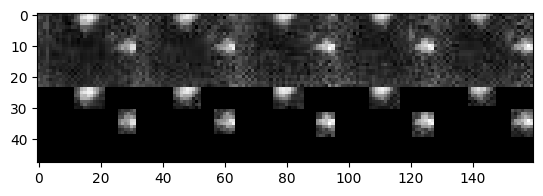

[2 2 2 2 2]
[[[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.29166667 1.         0.29166667 1.         0.58333333
   0.8125     0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.625      0.         0.625      0.25
   0.375      0.25      ]
  [0.78125    0.29166667 1.         0.29166667 1.         0.58333333
   0.78125    0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.33333333 1.         0.33333333 1.         0.625
   0.8125     0.625     ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  

In [31]:
imgs = np.concatenate([origin_images[1000:1005], target_images[1000:1005]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[1000:1005])

print(norm_location[1000:1005])

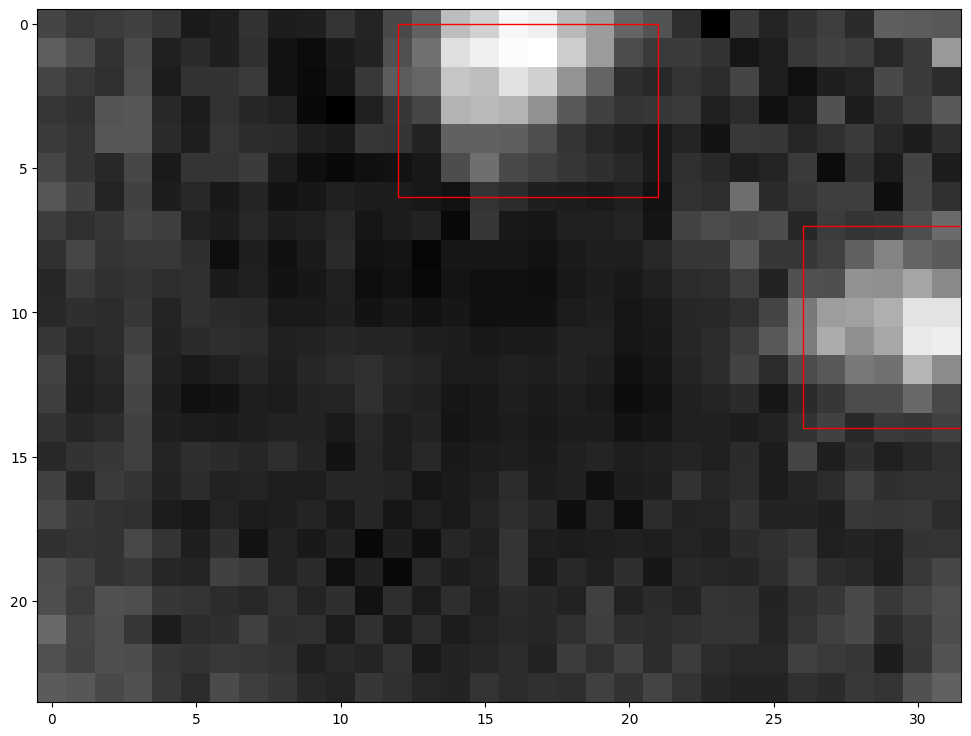

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes_on_image(image, normalized_coords, width=32, height=24):

    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]

    if image.ndim == 4:
        image = image[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()


draw_boxes_on_image(origin_images[1000:1001], norm_location[1000:1001])


In [84]:
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
from keras.layers import GRU, concatenate
from keras.models import Model

def DetectionModel():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))

    # Encoder 부분을 GRU로 구성
    x1 = Conv2D(32, (3, 3), padding='same')(inputs_image)
    x1 = BatchNormalization()(x1)  # BatchNorm 추가
    x1 = Activation('relu')(x1)
    
    x2 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = BatchNormalization()(x2)  # BatchNorm 추가
    x2 = Activation('relu')(x2)
    
    x3 = Conv2D(64, (3, 3), strides=(4, 4), padding='same')(x2)
    x3 = BatchNormalization()(x3)  # BatchNorm 추가
    x3 = Activation('relu')(x3)
    
    gru = Reshape((6, 8*64))(x3)
    
    gru = GRU(64, return_sequences=True)(gru)
    gru = GRU(64)(gru)
    
    latent_vector = Dense(48)(gru)
    latent_vector = BatchNormalization()(latent_vector)  # BatchNorm 추가
    latent_vector = Activation('relu')(latent_vector)
    
    # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    
    d1 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
    d1 = BatchNormalization()(d1)  # BatchNorm 추가
    d1 = Activation('relu')(d1)
    
    d2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)  # BatchNorm 추가
    d2 = Activation('relu')(d2)
    
    d3 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)  # BatchNorm 추가
    d3 = Activation('relu')(d3)

    d3 = concatenate([d3, x1])
    
    reconstructed_image = Conv2DTranspose(filters=1, kernel_size=3, padding='same', activation='sigmoid')(d3)
    
    # 추가적인 출력 계층 (좌표 예측)
    coords_output = Dense(4*8, activation='tanh')(latent_vector)
    coords_output = Reshape((4, 8))(coords_output)  

    # 사람 수 예측 계층
    number_output = Dense(5, activation='softmax', name='number_output')(latent_vector)

    return Model(inputs_image, [reconstructed_image, number_output, coords_output])


In [85]:
model = DetectionModel()
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d_68 (Conv2D)          (None, 24, 32, 32)           320       ['input_21[0][0]']            
                                                                                                  
 batch_normalization_78 (Ba  (None, 24, 32, 32)           128       ['conv2d_68[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_78 (Activation)  (None, 24, 32, 32)           0         ['batch_normalization_78

In [4]:
import tensorflow as tf

def smooth_l1_loss(y_true, y_pred, delta=1.0):
    abs_diff = tf.abs(y_true - y_pred)
    loss = tf.where(tf.less(abs_diff, delta), 0.5 * tf.square(abs_diff), delta * (abs_diff - 0.5 * delta))
    return tf.reduce_mean(loss)

In [88]:
model.compile(
    optimizer='adam',
    loss=['mse', 'categorical_crossentropy', smooth_l1_loss], 
    # loss_weights=[1, 0.1],
    metrics = ['accuracy']
    )  # 재구성 손실과 좌표 손실을 조절하기 위해 loss_weights 사용

In [89]:
hist = model.fit(
    origin_images, [target_images, trian_labels, norm_location], 
    epochs=50,
    verbose = 1
)

Epoch 1/50


2023-11-02 21:32:01.407226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 21:32:01.829437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 21:32:01.904480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 21:32:02.599567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 21:32:02.721704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 7s 59ms/step - loss: 0.7343 - conv2d_transpose_39_loss: 0.0185 - number_output_loss: 0.6152 - reshape_45_loss: 0.1007 - conv2d_transpose_39_accuracy: 0.8315 - number_output_accuracy: 0.8257 - reshape_45_accuracy: 0.1147
Epoch 2/50
69/69 [==============================] - 3s 45ms/step - loss: 0.2575 - conv2d_transpose_39_loss: 0.0035 - number_output_loss: 0.2271 - reshape_45_loss: 0.0269 - conv2d_transpose_39_accuracy: 0.8345 - number_output_accuracy: 0.9355 - reshape_45_accuracy: 0.1769
Epoch 3/50
69/69 [==============================] - 3s 45ms/step - loss: 0.1591 - conv2d_transpose_39_loss: 0.0030 - number_output_loss: 0.1386 - reshape_45_loss: 0.0175 - conv2d_transpose_39_accuracy: 0.8345 - number_output_accuracy: 0.9628 - reshape_45_accuracy: 0.1694
Epoch 4/50
69/69 [==============================] - 3s 45ms/step - loss: 0.1355 - conv2d_transpose_39_loss: 0.0027 - number_output_loss: 0.1181 - reshape_45_loss: 0.0147 - conv2d_transpose_39_acc

In [132]:
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model
from keras.layers import GRU, Concatenate
from keras.models import Model
from keras.layers import Multiply

def DetectionModel():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))

    # Encoder 부분을 GRU로 구성
    x1 = Conv2D(32, (3, 3), padding='same')(inputs_image)
    x1 = BatchNormalization()(x1)  # BatchNorm 추가
    x1 = Activation('relu')(x1)
    
    x2 = Conv2D(64, (3, 3), padding='same')(x1)
    x2 = BatchNormalization()(x2)  # BatchNorm 추가
    x2 = Activation('relu')(x2)
    
    x3 = Conv2D(64, (3, 3), strides=(4, 4), padding='same')(x2)
    x3 = BatchNormalization()(x3)  # BatchNorm 추가
    x3 = Activation('relu')(x3)
    
    gru = Reshape((6, 8*64))(x3)
    
    gru = GRU(64, return_sequences=True)(gru)
    gru = GRU(64)(gru)
    
    latent_vector = Dense(48)(gru)
    latent_vector = BatchNormalization()(latent_vector)  # BatchNorm 추가
    latent_vector = Activation('relu')(latent_vector)
    
    # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    
    d1 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
    d1 = BatchNormalization()(d1)  # BatchNorm 추가
    d1 = Activation('relu')(d1)
    
    d2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(d1)
    d2 = BatchNormalization()(d2)  # BatchNorm 추가
    d2 = Activation('relu')(d2)
    
    d3 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(d2)
    d3 = BatchNormalization()(d3)  # BatchNorm 추가
    d3 = Activation('relu')(d3)

    d3 = concatenate([d3, x1])
    
    reconstructed_image = Conv2DTranspose(filters=1, kernel_size=3, padding='same', activation='sigmoid')(d3)

    # 사람 수 예측 계층
    number_output = Dense(5, activation='softmax', name='number_output')(latent_vector)

    def attention_block(x):
        attention = Conv2D(1, (1, 1), activation='sigmoid')(x)
        multiplied = Multiply()([x, attention])
        return multiplied

    # 복구된 이미지에 Attention 메커니즘 적용
    attention_output = attention_block(reconstructed_image)
    
    # Attention이 적용된 이미지를 Flatten
    flattened_attention = Flatten()(attention_output)
    
    # number_output의 정보를 Dense layer를 통해 압축
    compressed_number_output = Dense(32, activation='relu')(number_output)
    
    # Attention 정보와 number_output 정보를 통합
    merged_info = Concatenate()([flattened_attention, compressed_number_output])
    
    # 통합된 정보를 기반으로 좌표 예측 네트워크 구성
    x = Dense(256, activation='tanh')(merged_info)
    x = Dropout(0.2)(x)  # Overfitting 방지를 위한 Dropout. 필요에 따라 조절 가능
    x = Dense(128, activation='tanh')(x)
    x = Dropout(0.2)(x)  # Overfitting 방지를 위한 Dropout. 필요에 따라 조절 가능
    coords_output = Dense(4*8, activation='sigmoid')(x)
    coords_output = Reshape((4, 8))(coords_output)

    return Model(inputs_image, [reconstructed_image, number_output, coords_output])


In [133]:
model = DetectionModel()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d_103 (Conv2D)         (None, 24, 32, 32)           320       ['input_30[0][0]']            
                                                                                                  
 batch_normalization_141 (B  (None, 24, 32, 32)           128       ['conv2d_103[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_141 (Activation  (None, 24, 32, 32)           0         ['batch_normalization_1

In [136]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer='adam',
    loss=['mse', 'categorical_crossentropy', smooth_l1_loss], 
    # loss_weights=[1, 0.1],
    metrics=['accuracy', Precision(), Recall()]
    )  # 재구성 손실과 좌표 손실을 조절하기 위해 loss_weights 사용

hist = model.fit(
    origin_images, [target_images, trian_labels, norm_location], 
    epochs=50,
    verbose = 1
)

Epoch 1/50


2023-11-02 22:06:41.406231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 22:06:42.125276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 22:06:42.254239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 22:06:44.139983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 22:06:44.303623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 14s 124ms/step - loss: 0.7531 - conv2d_transpose_75_loss: 0.0260 - number_output_loss: 0.7106 - reshape_72_loss: 0.0166 - conv2d_transpose_75_accuracy: 0.8233 - conv2d_transpose_75_precision: 0.7185 - conv2d_transpose_75_recall: 0.1718 - number_output_accuracy: 0.7926 - number_output_precision: 0.8939 - number_output_recall: 0.6655 - reshape_72_accuracy: 0.2515 - reshape_72_precision: 0.9121 - reshape_72_recall: 0.3711
Epoch 2/50
69/69 [==============================] - 4s 62ms/step - loss: 0.2384 - conv2d_transpose_75_loss: 0.0041 - number_output_loss: 0.2285 - reshape_72_loss: 0.0058 - conv2d_transpose_75_accuracy: 0.8344 - conv2d_transpose_75_precision: 0.9961 - conv2d_transpose_75_recall: 0.2452 - number_output_accuracy: 0.9464 - number_output_precision: 0.9535 - number_output_recall: 0.9315 - reshape_72_accuracy: 0.2682 - reshape_72_precision: 0.9853 - reshape_72_recall: 0.4410
Epoch 3/50
69/69 [==============================] - 4s 60ms/ste

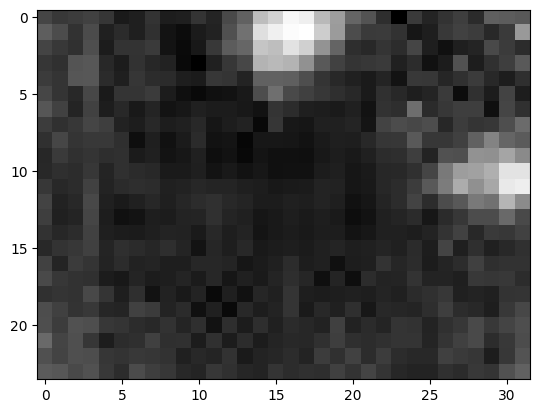

1/1 [==============================] - 0s 64ms/step
2


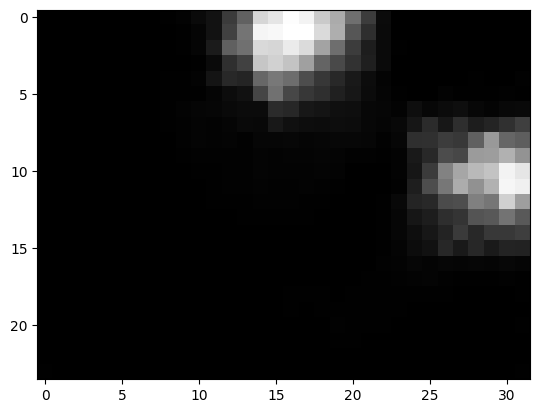

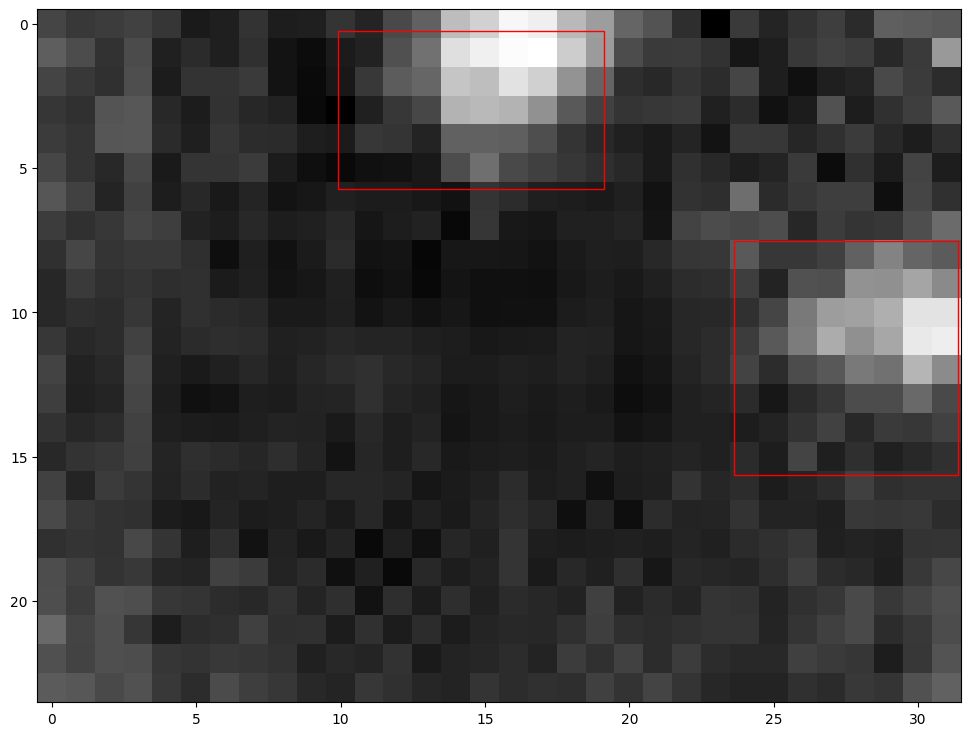

In [33]:

plt.imshow(origin_images[1000], cmap='gray')
plt.show()
res = model.predict(origin_images[1000:1001])
# print(origin_images[2000:2001].shape)
# images = np.concatenate([origin_images[110:115],  target_images[110:115], res[0][:6]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

# plt.imshow(images, cmap='gray')
# plt.show()

# print(res[1][:6])
# print(res[1][:6])
# [reconstructed_image, number_output, coords_output])
plt.imshow(res[0][0], cmap='gray')
print(res[1].argmax())
draw_boxes_on_image(origin_images[1000:1001], res[2][:])


In [8]:
import tensorflow as tf

def smooth_l1_loss(y_true, y_pred, delta=1.0):
    abs_diff = tf.abs(y_true - y_pred)
    loss = tf.where(tf.less(abs_diff, delta), 0.5 * tf.square(abs_diff), delta * (abs_diff - 0.5 * delta))
    return tf.reduce_mean(loss)

In [11]:
model = keras.models.load_model('/home/pi/modelTest/detection_v2.h5', custom_objects={'smooth_l1_loss': smooth_l1_loss})

    

In [14]:

dataset = np.load('/home/pi/modelTest/detection_dataset.npz', allow_pickle=True)


origin_images, target_images, number_labels, coordinates = dataset['images'], dataset['filters'], dataset['numbers'],  dataset['coordinates']


print(origin_images.shape)
print(target_images.shape)
print(number_labels.shape)
print(coordinates.shape)


(2203, 24, 32)
(2203, 24, 32)
(2203,)
(2203, 4, 8)


In [19]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes_on_image(image, normalized_coords, width=32, height=24):

    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]

    if image.ndim == 4:
        image = image[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()


In [21]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

255 0
255 0
1.0 0.0
1.0 0.0


(5, 48, 32, 1)


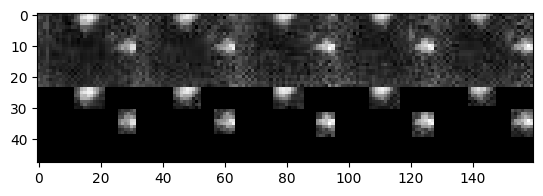

[2 2 2 2 2]
[[[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.29166667 1.         0.29166667 1.         0.58333333
   0.8125     0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.625      0.         0.625      0.25
   0.375      0.25      ]
  [0.78125    0.29166667 1.         0.29166667 1.         0.58333333
   0.78125    0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.33333333 1.         0.33333333 1.         0.625
   0.8125     0.625     ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  

In [34]:
imgs = np.concatenate([origin_images[1000:1005], target_images[1000:1005]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[1000:1005])

print(norm_location[1000:1005])

In [35]:
import os
import re
import cv2
import numpy as np

def extract_number(filename):
    match = re.search(r'(\d+)_png', filename)
    if match:
        return int(match.group(1))
    return None

def make_video_from_images(image_folder, video_name, fps=10.0):
    # 이미지 폴더 내의 모든 파일들을 가져옵니다.
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

    # 숫자 기준으로 이미지들을 정렬합니다.
    images.sort(key=extract_number)

    # 첫 번째 이미지를 통해 프레임의 너비와 높이를 가져옵니다.
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    h, w, layers = frame.shape
    size = (w, h)

    # VideoWriter 객체를 초기화합니다.
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    # 이미지들을 하나씩 동영상에 추가합니다.
    for image in images:
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        out.write(img)

    # 작업 완료 후, VideoWriter 객체를 해제합니다.
    out.release()

def save_draw_boxes_on_image(image, normalized_coords, save_path, num_people=None, width=32, height=24):
    normalized_coords = normalized_coords.squeeze()
    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]
    if image.ndim == 4:
        image = image[0]
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')
    if num_people is not None:
        ax.text(0.5, 0.1, f"Number of people: {num_people}", 
                transform=ax.transAxes, 
                color='white', 
                ha="center", 
                va="center", 
                fontsize=12, 
                bbox=dict(boxstyle="round", fc="red"))
    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the axis
        ax.add_patch(rect)
    plt.savefig(save_path)
    plt.close()  # 이 라인을 추가하여 화면에 표시되는 창을 닫습니다.
    return save_path

def generate_video_from_images():
    # 예측할 이미지 경로(예측 후 동영상으로 변환될 이미지)
    image_dir = '/home/pi/modelTest/img/'
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=extract_number)
    print(image_files)
    frame_height, frame_width = 24, 32
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        img = img.reshape(24, 32, 1)
        img_batch = np.expand_dims(img, axis=0)
        res = model.predict(img_batch / img_batch.max())
        # 예측 한 이미지를 저장할 폴더
        output_folder = "/home/pi/modelTest/predict/"
        save_path = os.path.join(output_folder, image_file)

        saved_image_path = save_draw_boxes_on_image(img, res[2][:], save_path, res[1].argmax())
        saved_image_gray = cv2.imread(saved_image_path, cv2.IMREAD_GRAYSCALE)
        
        saved_image = cv2.cvtColor(saved_image_gray, cv2.COLOR_GRAY2BGR)

    # 이 부분에서 이미지들을 동영상으로 만드는 함수를 호출합니다.
    # 예측 한 이미지를 저장할 폴더와 같은 폴더
    image_folder = '/home/pi/modelTest/predict/'  # 이미지 폴더 경로
    video_name = '/home/pi/modelTest/video/video.avi'  # 저장될 동영상 파일 이름
    make_video_from_images(image_folder, video_name)
    print("Video generated successfully.")

if __name__ == "__main__":
    generate_video_from_images()


['0_png.png', '1_png.png', '2_png.png', '3_png.png', '4_png.png', '5_png.png', '6_png.png', '7_png.png', '8_png.png', '9_png.png', '10_png.png', '11_png.png', '12_png.png', '13_png.png', '14_png.png', '15_png.png', '16_png.png', '17_png.png', '18_png.png', '19_png.png', '20_png.png', '21_png.png', '22_png.png', '23_png.png', '24_png.png', '25_png.png', '26_png.png', '27_png.png', '28_png.png', '29_png.png', '30_png.png', '31_png.png', '32_png.png', '33_png.png', '34_png.png', '35_png.png', '36_png.png', '37_png.png', '38_png.png', '39_png.png', '40_png.png', '41_png.png', '42_png.png', '43_png.png', '44_png.png', '45_png.png', '46_png.png', '47_png.png', '48_png.png', '49_png.png', '50_png.png', '51_png.png', '52_png.png', '53_png.png', '54_png.png', '55_png.png', '56_png.png', '57_png.png', '58_png.png', '59_png.png', '60_png.png', '61_png.png', '62_png.png', '63_png.png', '64_png.png', '65_png.png', '66_png.png', '67_png.png', '68_png.png', '69_png.png', '70_png.png', '71_png.png', '

: 